### Ted Translater Data
- 원본 코드 : https://www.tensorflow.org/tutorials/text/transformer
- 포르투갈어 -> 영어 번역
- num_layers = 4
- d_model = 128 : Embedding Vector's dimension, Encoder와 Decoder에서의 정해진 입력과 출력의 크기
- num_heads = 8 : 여러번의 Attention을 병렬로 수행하는 횟수, num_head만큼 다시 concatenate
- d_k = d_model / num_heads = 128 / 8 = 18 : Q,K,V의 dimension

In [1]:
!pip install tensorflow-text

In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tf_dataset
import tensorflow_text as tf_text
import tensorflow as tf

In [3]:
# data 불러오기
# dataset reference : https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate
examples, metadata = tf_dataset.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

In [4]:
examples

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>}

In [5]:
metadata # data 정보 요약

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [6]:
train_examples, val_examples = examples['train'], examples['validation']

In [7]:
# examples check
for pt_examples, en_examples in train_examples.batch(3).take(2): # batch_size 3으로 나누고 그 중 2개 가져오기
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
`` `` '' podem usar tudo sobre a mesa no meu corpo . ''
`` eu escrevo muito acerca do `` '' teatro de segurança '' '' , que são produtos que fazem as pessoas sentirem-se seguras mas que , na realidade , não fazem nada . ''
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''


In [8]:
# load tokenizer
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip", # f'' : f-string formatting
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(model_name)

In [9]:
print([item for item in dir(tokenizers.en)])

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_deferred_dependencies', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_preload_simple_restoration', '_reserved_tokens', '_restore_from_checkpoint_position', '_self_name_based_restores', '_self_saveable_object_factories', '_self_setattr_tracking', '_self_unconditional_checkpoint_dependencies', '_self_unconditional

In [10]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''


In [11]:
encoded = tokenizers.en.tokenize(en_examples)
print("Tokenize")
for row in encoded.to_list():
  print(row)

round_trip = tokenizers.en.detokenize(encoded)
print("De-Tokenize")
for line in round_trip.numpy():
  print(line.decode('utf-8'))  

Tokenize
[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]
[2, 79, 94, 212, 299, 92, 71, 1356, 92, 114, 15, 3]
[2, 36, 36, 45, 712, 37, 199, 95, 36, 36, 9, 9, 892, 3270, 13, 9, 9, 9, 9, 148, 86, 1321, 75, 161, 104, 309, 1871, 13, 87, 91, 50, 9, 56, 150, 91, 440, 15, 9, 9, 3]


De-Tokenize
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
` ` i write a lot about ` ` ' ' security theater , ' ' ' ' which are products that make people feel secure , but do n ' t actually do anything . ' '


In [12]:
# lookup : 토큰 ID값을 토큰 텍스트값으로 변환
tokens = tokenizers.en.lookup(encoded)
print(tokens)
print(encoded)

<tf.RaggedTensor [[b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance', b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic', b',', b'can', b'still', b'have', b'faith', b'.', b'[END]'], [b'[START]', b'you', b'can', b'use', b'everything', b'on', b'the', b'table', b'on', b'me', b'.', b'[END]'], [b'[START]', b'`', b'`', b'i', b'write', b'a', b'lot', b'about', b'`', b'`', b"'", b"'", b'security', b'theater', b',', b"'", b"'", b"'", b"'", b'which', b'are', b'products', b'that', b'make', b'people', b'feel', b'secure', b',', b'but', b'do', b'n', b"'", b't', b'actually', b'do', b'anything', b'.', b"'", b"'", b'[END]']]>
<tf.RaggedTensor [[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3], [2, 79, 94, 212, 299, 92, 71, 1356, 92, 114, 15, 3], [2, 36, 36, 45, 712, 37, 199, 95, 36, 36, 9, 9, 892, 3270, 13, 9, 9, 9, 9, 148, 86, 1321, 75, 161, 104, 309, 1871, 13, 87, 91, 50, 9, 56, 150, 91, 440, 15, 9, 9, 3]]>

In [13]:
# Set-up input pipeline(입력 파이프라인 설정)

def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt) # 포르투갈어 tokenizer
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor() # token to tensor

    en = tokenizers.en.tokenize(en) # 영어 tokenizer
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor() # token to tensor
    return pt, en # 각 언어별 tensor 반환

BUFFER_SIZE = 20000
BATCH_SIZE  = 64

def make_batches(data_samples): # 참고 : https://www.javaer101.com/ko/article/818183.html
    return (data_samples
            .cache() # 캐시: 데이터나 값을 미리 복사해 놓는 임시 장소, 접근 시간에 비해 원래 데이터를 접근하는 시간이 오래 걸리는 경우나 값을 다시 계산하는 시간을 절약하고 싶은 경우에 사용
            .shuffle(BUFFER_SIZE) # 버퍼 : 데이터를 한 곳에서 다른 한 곳으로 전송하는 동안 일시적으로 그 데이터를 보관하는 메모리의 영역, 버퍼링이란 버퍼를 활용하는 방식 또는 버퍼를 채우는 동작을 말함. 다른 말로 '큐'라고도 표현
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls : 병렬 연산 갯수? 타 코드에서 숫자로 입력해주는 경우도 있음
            .prefetch(tf.data.AUTOTUNE) # tf.data.AUTOTUNE : tf.data 런타임 실행 시 동적으로 값을 조정 // 참고 : https://www.tensorflow.org/guide/data_performance?hl=ko
           ) # prefetch : 컴퓨터 프로세서가 명령이나 데이터를 원래 메모리에서 느린 메모리의 빠른 로컬 메모리로 가져 와서 실제로 필요로 하기 전에 실행 성능을 높이기 위해 사용하는 기술

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

### 함수 정의

In [14]:
# Hyper-Parameter 설정
num_layers = 4
d_model = 128
dff = 512 # Feed Forward NN
num_heads = 8
dropout_rate = 0.1

In [15]:
# Positional Encoding(위치 인코딩) : 단어의 위치정보를 얻기 위해 각 단어의 임베딩 벡터에 위치정보들을 더하여 모델의 입력으로 사용
## 이론 참고 : https://wikidocs.net/31379
def get_angles(pos, i, d_model): # pos : 임베딩 벡터의 위치, i : 벡터 내 차원의 인덱스, d_model : 임베딩 벡터의 차원
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates # 하단 이미지 참고

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], # np.newaxis : 벡터 차원을 늘려줌 // 참고 : https://azanewta.tistory.com/3
                          np.arange(d_model)[np.newaxis, :],  ## arr = np.arange(4)로 생성한 (4,) 벡터에 arr[:, np.newaxis]를 적용하면 (4,1) 형태로 변환
                          d_model)                            ## reshape과 차이 : reshape는 (4,1) -> (2,2)와 같이 숫자가 딱 떨어지는 경우에만 가능, 새로 만들기 X

  # apply sin to even indices in the array; 2i(인덱스 짝수일때 sin함수 적용)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  ## 0부터 2씩 건너서 ~ sin함수 적용
  # apply cos to odd indices in the array; 2i+1(인덱스 홀수일때 cos함수 적용)
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  ## 1부터 2씩 건너서 ~ cos함수 적용
  pos_encoding = angle_rads[np.newaxis, ...] # ... : 전체 선택 // 참고 : https://numpy.org/doc/stable/reference/arrays.indexing.html ~ Ellipsis

  return tf.cast(pos_encoding, dtype=tf.float32) # float32 type으로 변환

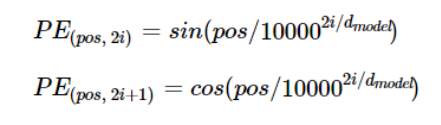

In [16]:
n, d = 2048, 512
pos_encoding = positional_encoding(n,d)
print(pos_encoding.shape) # (1, 2048, 512)
pos_encoding = pos_encoding[0] # pos_encoding.shape : TensorShape([2048, 512])

(1, 2048, 512)


In [17]:
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2)) # (2048, 256, 2)
pos_encoding = tf.transpose(pos_encoding, (2,1,0)) # (2, 256, 2048)
pos_encoding = tf.reshape(pos_encoding, (d, n)) # (512, 2048)

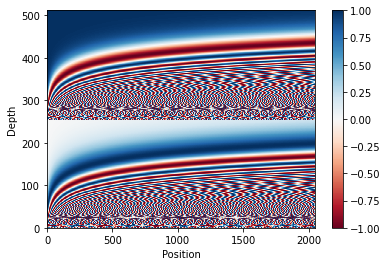

In [18]:
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [19]:
# Masking : padding 부분을 입력으로 취급하지 않도록 가려줌
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
'''
Ex)
x = tf.constant([
                 [7, 6, 0, 0, 1],
                 [1, 2, 3, 0, 0],
                 [0, 0, 0, 4, 5]
                ])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>
'''

def create_look_ahead_mask(size): 
    # 참고 : https://tensorflow.google.cn/api_docs/python/tf/linalg/band_part
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # lower triangular matrix
    return mask  # (seq_len, seq_len)
'''
Ex)
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>
'''

'\nEx)\nx = tf.random.uniform((1, 3))\ntemp = create_look_ahead_mask(x.shape[1])\ntemp\n\n<tf.Tensor: shape=(3, 3), dtype=float32, numpy=\narray([[0., 1., 1.],\n       [0., 0., 1.],\n       [0., 0., 0.]], dtype=float32)>\n'

### Scaled Dot Product Attention
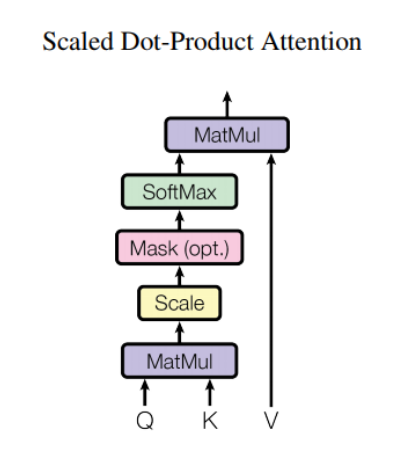

In [20]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension(끝에서 두번째 dimension), i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  
  추가 참고 : http://machinelearningkorea.com/2019/07/09/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8-transformer%EC%99%80-%EC%96%B4%ED%85%90%EC%85%98-attention%EC%9D%84-%ED%86%B5%ED%95%B4%EC%84%9C-bert%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0/
    Q, K, V : 훈련과정에서 나온 토큰들의 선형변환으로 튀어나오는 벡터
  ("사랑"이라는 단어가 "통계"라는 단어와 얼마나 연관성이 있는지 알아볼 때)
  Query는 우리가 찾아야할 의미를 가지고 있는 토큰(사랑)
  Key는 거기에 얼마나 연관되어있나를 찾아야할 토큰(통계)
  Values는 실질적인 컨텐츠가 되겠습니다.  
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k) # q, k 연산에서 연관성 값 구함

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32) # d_k = d_model / num_heads
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # 하단 식 참고

  # add the mask to the scaled tensor.
  if mask is not None: # optional mask
    scaled_attention_logits += (mask * -1e9)  # -1 x 10^9, 매우 작은 음수

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v) // qk x v -> 연관성 값이 연산된 벡터값 계산

  return output, attention_weights

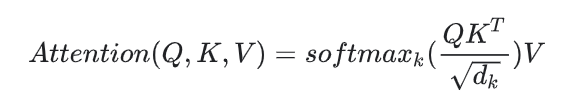

In [21]:
# scaled_dot_product_attention 함수 결과값 출력
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Output is:')
  print (temp_out)
  print ('Attention weights are:')
  print (temp_attn)

'''
Ex)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

>>> Attention weights are:
    tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
    Output is:
    tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

>>> Attention weights are:
    tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
    Output is:
    tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

>>> Attention weights are:
    tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
    Output is:
    tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)

# 위의 예시에 사용된 모든 q 전달 시 결과값
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

>>> Attention weights are:
    tf.Tensor(
    [[0.  0.  0.5 0.5]
    [0.  1.  0.  0. ]
    [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
    Output is:
    tf.Tensor(
    [[550.    5.5]
    [ 10.    0. ]
    [  5.5   0. ]], shape=(3, 2), dtype=float32)
'''

'\nEx)\ntemp_k = tf.constant([[10,0,0],\n                      [0,10,0],\n                      [0,0,10],\n                      [0,0,10]], dtype=tf.float32)  # (4, 3)\n\ntemp_v = tf.constant([[   1,0],\n                      [  10,0],\n                      [ 100,5],\n                      [1000,6]], dtype=tf.float32)  # (4, 2)\n\n# This `query` aligns with the second `key`,\n# so the second `value` is returned.\ntemp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)\nprint_out(temp_q, temp_k, temp_v)\n\n>>> Attention weights are:\n    tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)\n    Output is:\n    tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)\n\n# This query aligns with a repeated key (third and fourth), \n# so all associated values get averaged.\ntemp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)\nprint_out(temp_q, temp_k, temp_v)\n\n>>> Attention weights are:\n    tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)\n    Output is:\n   

### Multi-Head Attention
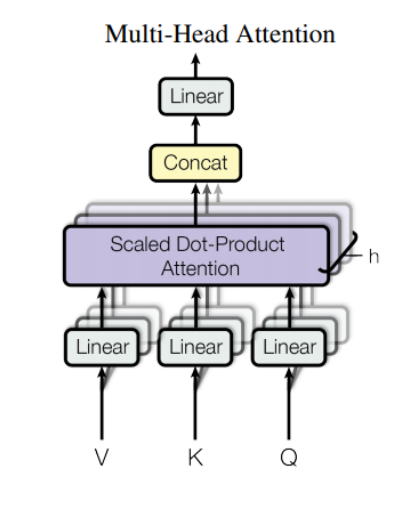

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
# V, K, Q를 각각 Linear 연산 -> head 개수에 맞게 split
# -> num_head 번의 (dot-product attention -> scaling) 연산을 병렬 수행한 후 concat -> Linear
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 8
    self.d_model = d_model # 128

    assert d_model % self.num_heads == 0 # assert : 조건에 맞을 시에만 하단 코드 동작

    self.depth = d_model // self.num_heads # depth '16' x num_heads 8 = d_model 128

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """
    Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3]) # perm : 하단 참고 // (batch_size, num_heads, seq_len, depth)

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    print_out(q,k,v)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights


In [23]:
# perm 함수 참고 (permutation 약자인듯)
x = tf.constant([
                 [
                  [ 1,  2,  3,  4],
                  [ 5,  6,  7,  8],
                  [ 9, 10, 11, 12]
                 ],
                 [
                  [13, 14, 15, 16],
                  [17, 18, 19, 20],
                  [21, 22, 23, 24]
                 ]
                ])
print(x.shape)
tf.transpose(x, perm=[0, 2, 1])

(2, 3, 4)


<tf.Tensor: shape=(2, 4, 3), dtype=int32, numpy=
array([[[ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11],
        [ 4,  8, 12]],

       [[13, 17, 21],
        [14, 18, 22],
        [15, 19, 23],
        [16, 20, 24]]], dtype=int32)>

In [24]:
# Multi-Head-Attention Test
temp_MHA = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1,60,512)) # (batch_size, encoder_sequence, d_model)
out, attn = temp_MHA(y, k=y, q=y, mask=None) # v=y
out.shape, attn.shape

Output is:
tf.Tensor(
[[[[-0.02108884 -0.34756747  0.37547892 ... -0.5953823  -0.29387796
    -0.38122222]
   [-0.01788441 -0.3400119   0.37954357 ... -0.5941803  -0.29334974
    -0.38593134]
   [-0.02162916 -0.32975093  0.37683982 ... -0.5990417  -0.2987137
    -0.38127056]
   ...
   [-0.02374479 -0.33594626  0.3742684  ... -0.5960774  -0.2938736
    -0.38301283]
   [-0.02064421 -0.34564036  0.3714344  ... -0.5957574  -0.29120317
    -0.384829  ]
   [-0.01844211 -0.34267431  0.38001788 ... -0.6006751  -0.29107752
    -0.37961745]]

  [[ 0.76315826 -0.03794472  0.545484   ...  0.21902569  0.00263234
     0.66284966]
   [ 0.7687476  -0.03029691  0.5471054  ...  0.22073579 -0.00741275
     0.6664463 ]
   [ 0.7656924  -0.03522818  0.5480318  ...  0.2146645  -0.00569896
     0.6634976 ]
   ...
   [ 0.77055746 -0.03718945  0.5462756  ...  0.2178155  -0.00373188
     0.66628087]
   [ 0.7655446  -0.02909066  0.5488426  ...  0.2312271  -0.00577729
     0.6656155 ]
   [ 0.7678479  -0.02862723  

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [25]:
# Point-wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

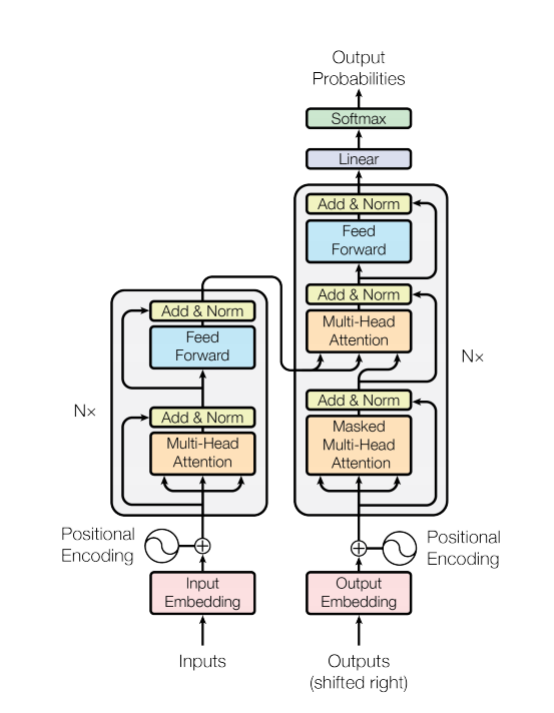
- Transfomer Model은 Attention Model의 일반적인 패턴을 따른다
- Input Sentence -> N개의 Encoder -> 단어 및 토큰 Output
- Encoder Output + Self-attention -> Decoder -> 다음 단어 예측 

### Layer 구성

In [26]:
# Encoder Layer
## Multi-Head-Attention + Point-wise Feed Forward + Residual + Normalize
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    #Encoder Self-Attention
    attn_output, _ = self.mha(x, x, x, mask)  # (v=x, k=x, q=x) / (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [27]:
# Decoder Layer
## Masked-Multi-Head-Attention + Multi-Head-Attention with Padding Mask + Point-wise Feed Forward + Residual + Normalize
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    # Decoder Self-Attention
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (v=x,k=x,q=x) / (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    # Encoder-Decoder Attention
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (v=enc_output, k=enc_output, q=out1=decoder self-attention output) / (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [28]:
# Encoder
## Input Embedding + Positional Encoding + N Encoding Layers
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [29]:
# Decoder
## Output Embedding + Positional Encoding + N Decoder Layers
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [30]:
# Transfomer
## Encoder + Decoder + Linear Layer
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  # call : 객체 생성 이후 부를 때 인자 받는 듯
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [31]:
# Optimizer : 논문 공식에 따라 스케쥴러 함수 지정
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)


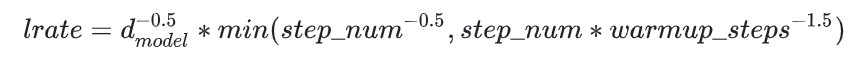
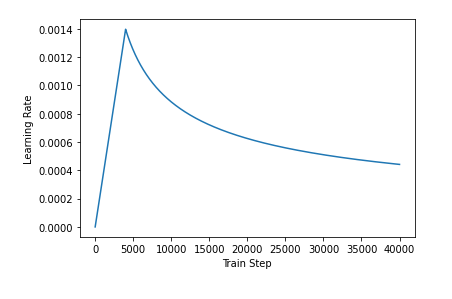

### Training

In [32]:
# Loss / Metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # logical_not : real == 0 -> True -(logical_not)- > False( 0 )
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask # target_sequence의 padding 값으로 들어간 0은 loss라고 인식하여 값을 계산 하지 않게끔 mask에서 0이었던 부분들은 0을 곱해 줌

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask) # reduce_sum : 모든 elements의 합


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0)) # real == 0 -> True -(logical_not)> False
  accuracies = tf.math.logical_and(mask, accuracies)
  # logical_and :mask == accuracies ~ (logical_and ~ 0 있으면 무조건 0)  
  # 즉, padding으로 들어갔던 부분도 0, real과 비교하여 틀린 부분도 0으로 바꿔 정확도 계산기 reduce_sum 값에 영향을 주지 않음
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [33]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(), # 7765
    target_vocab_size=tokenizers.en.get_vocab_size(), # 7010 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)

In [34]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [35]:
# checkpoint
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [36]:
EPOCHS = 30

# The @tf.function trace-compiles train_step into a TF graph for faster execution.
# The function specializes to the precise shape of the argument tensors.
# To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape: # torch에서 forward와 같이 경사하강법 및 학습 수행
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [37]:
# Training
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Output is:
Tensor("transformer/encoder/encoder_layer/multi_head_attention_1/MatMul_3:0", shape=(None, 8, None, 16), dtype=float32)
Attention weights are:
Tensor("transformer/encoder/encoder_layer/multi_head_attention_1/Softmax_1:0", shape=(None, 8, None, None), dtype=float32)
Output is:
Tensor("transformer/encoder/encoder_layer_1/multi_head_attention_2/MatMul_3:0", shape=(None, 8, None, 16), dtype=float32)
Attention weights are:
Tensor("transformer/encoder/encoder_layer_1/multi_head_attention_2/Softmax_1:0", shape=(None, 8, None, None), dtype=float32)
Output is:
Tensor("transformer/encoder/encoder_layer_2/multi_head_attention_3/MatMul_3:0", shape=(None, 8, None, 16), dtype=float32)
Attention weights are:
Tensor("transformer/encoder/encoder_layer_2/multi_head_attention_3/Softmax_1:0", shape=(None, 8, None, None), dtype=float32)
Output is:
Tensor("transformer/encoder/encoder_layer_3/multi_head_attention_4/MatMul_3:0", shape=(None, 8, None, 16), dtype=float32)
Attention weights are:
Tenso

### Evaluate

In [38]:
# Evaluate
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0] # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [39]:
# 실제 번역 테스트
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
    1.63595505e-05 7.68575628e-05 7.49346684e-04 1.79809984e-02
    8.44329596e-02 8.42242479e-01 5.43464422e-02]]

  [[1.07214309e-01 8.19780469e-01 6.86237961e-02 2.26894883e-03
    5.34270075e-04 5.26982942e-04 2.75906350e-04 7.83167343e-06
    1.67679775e-06 1.58586554e-04 6.07164227e-04]
   [3.50000151e-02 5.58645964e-01 4.01803941e-01 1.86095631e-03
    2.62943353e-03 2.04987209e-05 3.30229414e-05 8.67564864e-08
    1.22254932e-07 6.50372783e-07 5.32813783e-06]
   [1.76427647e-01 8.41734633e-02 8.13208427e-03 7.13249385e-01
    1.56624150e-02 2.31723720e-03 1.46669563e-05 2.25998319e-05
    9.93634615e-08 5.84858455e-08 3.67932643e-07]
   [6.37387997e-03 2.88347310e-05 2.99267413e-04 9.43482876e-01
    4.68732975e-02 2.72305799e-03 1.23265127e-04 9.21220999e-05
    2.82056271e-06 2.70482218e-07 2.95739483e-07]
   [8.46554935e-02 2.51923029e-05 1.23218186e-02 5.77165373e-03
    9.34171975e-02 7.96472311e-01 2.03347905e-03 5.14788227e-03
    1.89

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   [ 3.88512611e-01 -2.37541288e-01  3.39222923e-02 ... -1.06234002e+00
     5.28445095e-02  1.56307846e-01]
   [-1.70662582e-01  1.58892632e-01 -2.84326613e-01 ... -4.45221394e-01
     1.72199771e-01 -3.12991962e-02]
   [ 1.17880598e-01  5.07450104e-03 -1.83072716e-01 ... -3.48224312e-01
     7.31461942e-02  8.96033123e-02]]]], shape=(1, 8, 8, 16), dtype=float32)
Attention weights are:
tf.Tensor(
[[[[1.26209678e-02 1.45788074e-01 8.48842133e-03 4.92114462e-02
    1.52240843e-01 1.85153391e-02 1.22659728e-01 2.18647141e-02
    4.52984005e-01 1.56265423e-02]
   [6.69895858e-02 7.25014135e-02 3.06461573e-01 4.40643653e-02
    6.15047030e-02 1.59466397e-02 5.82133718e-02 9.10224244e-02
    1.57768533e-01 1.25527367e-01]
   [6.98127821e-02 6.53701603e-01 1.08200803e-01 7.03774840e-02
    6.66244775e-02 2.13571992e-02 9.77079268e-04 2.39880243e-03
    2.46909726e-03 4.08072630e-03]
   [1.11483261e-02 8.58687423e-03 1.54545177e-02 6.70526118e-04
    5.3723

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
     4.72171605e-01  1.75760329e-01]
   [ 2.43308976e-01  9.02892649e-02  4.42873128e-02 ... -1.81092784e-01
     3.76640201e-01  2.08481982e-01]
   [ 1.40354663e-01  5.98603971e-02 -1.05666623e-01 ... -2.73925513e-01
     1.07628919e-01  8.62360001e-02]
   ...
   [-2.25741304e-02  4.33015198e-01  2.50189677e-02 ... -1.18357241e-01
     3.04877430e-01  1.14775531e-01]
   [ 4.46785875e-02  7.93714076e-02 -3.78688246e-01 ... -2.50761975e-02
     8.69031064e-03 -8.87143686e-02]
   [ 7.17381090e-02  1.24116413e-01 -2.26784691e-01 ... -1.09813578e-01
    -1.21958792e-01 -1.81126475e-01]]

  [[-2.91494608e-01  3.73005509e-01  1.14459880e-01 ... -7.59279847e-01
     2.96211958e-01 -1.56106210e+00]
   [-1.61125094e-01  3.33313376e-01 -9.62887257e-02 ... -4.57134962e-01
     1.39566377e-01 -1.06696141e+00]
   [-4.93222415e-01  4.70521033e-01 -1.37135491e-01 ... -4.11839962e-01
    -4.97236878e-01 -5.13914645e-01]
   ...
   [ 5.37318923e-02  3.22260737e-01  1.

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly share with you some stories of magic things that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


### Attention Plot

In [40]:
# Attention Plot
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it. 
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))


  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [41]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([20, 20])

In [42]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   [3.54326027e-03 2.36459837e-05 3.97097931e-04 4.41274569e-05
    2.08953774e-04 9.94531214e-01 1.24564592e-03 4.48759329e-06
    9.27898100e-07 2.88587955e-07 2.72317550e-07]
   [3.46956216e-03 4.59361800e-05 3.09426017e-04 1.95458671e-03
    4.84678458e-04 1.86031801e-03 1.47561608e-02 9.29232955e-01
    4.71934900e-02 4.18885989e-04 2.73951737e-04]
   [2.61934055e-03 1.33673777e-04 5.32344915e-04 1.63612247e-04
    5.51036392e-05 2.61902576e-04 2.39734654e-03 2.24334095e-03
    9.91387069e-01 1.53133704e-04 5.30857214e-05]]

  [[5.29706180e-02 6.64031282e-02 1.28670007e-01 1.40228957e-01
    3.05749159e-02 1.24178119e-01 3.16818416e-01 8.85571167e-02
    1.08532999e-02 3.56922187e-02 5.05320029e-03]
   [1.53932586e-01 1.30466715e-01 1.87032446e-02 3.74359116e-02
    2.50833873e-02 3.79366241e-02 9.28567648e-02 4.81749028e-02
    1.16120808e-01 1.29875302e-01 2.09413767e-01]
   [4.22040448e-02 1.35613894e-02 1.21106328e-02 1.80578958e-02
    6.56

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [43]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

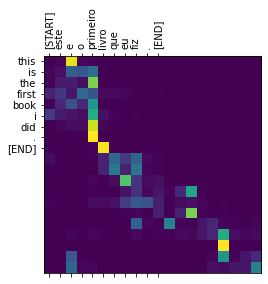

In [44]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [45]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel('Head {}'.format(h+1))

  plt.tight_layout()
  plt.show()

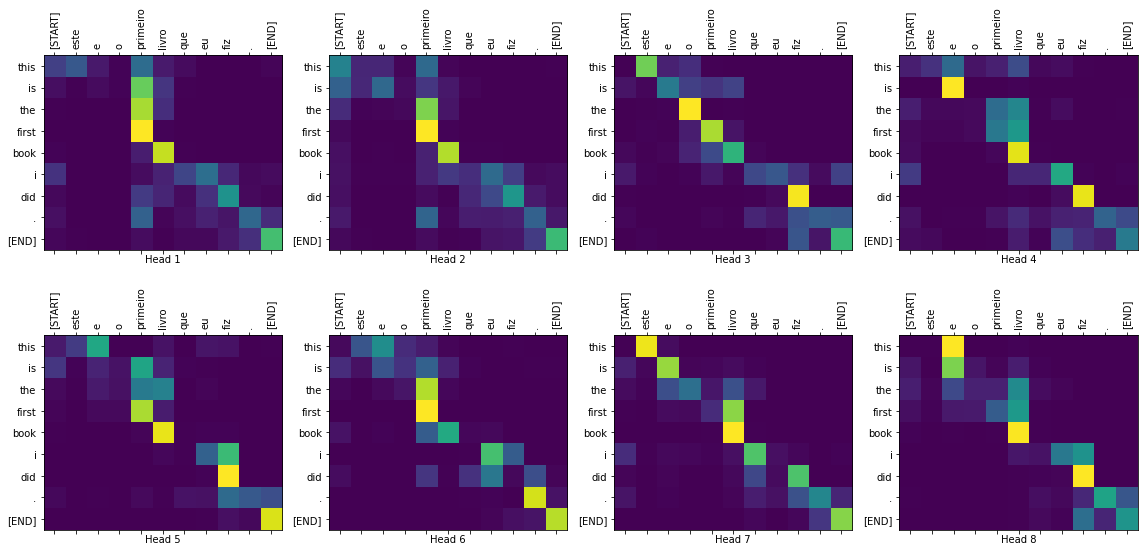

In [46]:
plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block2'][0])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   [-0.10313673 -0.18938607  0.01867108 ... -0.09178603 -0.15681529
     0.00232086]
   ...
   [ 0.39568555 -0.25888416  0.27728173 ... -0.1978903  -0.12740698
     0.00182617]
   [ 0.30650842 -0.27098516  0.06126545 ... -0.3062995  -0.23107319
    -0.03558035]
   [ 0.19939402 -0.17978354  0.1607259  ... -0.23236203 -0.02611507
    -0.0886218 ]]

  [[ 0.08419442  0.3494979   0.08290149 ... -0.46774197  0.20310459
    -0.46089017]
   [ 0.12806202  0.39127624  0.10475656 ... -0.1801606  -0.0642776
    -0.30237868]
   [ 0.18400162  0.25479344 -0.08718583 ... -0.05689347 -0.47931764
     0.04480745]
   ...
   [ 0.24186511  0.16870189 -0.03275105 ... -0.16878122  0.2946299
     0.27747774]
   [ 0.30170143  0.11324657 -0.07650361 ...  0.0608311   0.44258752
     0.5492215 ]
   [ 0.254363    0.13697429 -0.08088192 ...  0.02785785  0.4605993
     0.40079618]]

  [[ 0.8037316  -0.953948    0.7140138  ... -0.91734654 -0.06984422
     0.04064673]
   [ 0.7427162

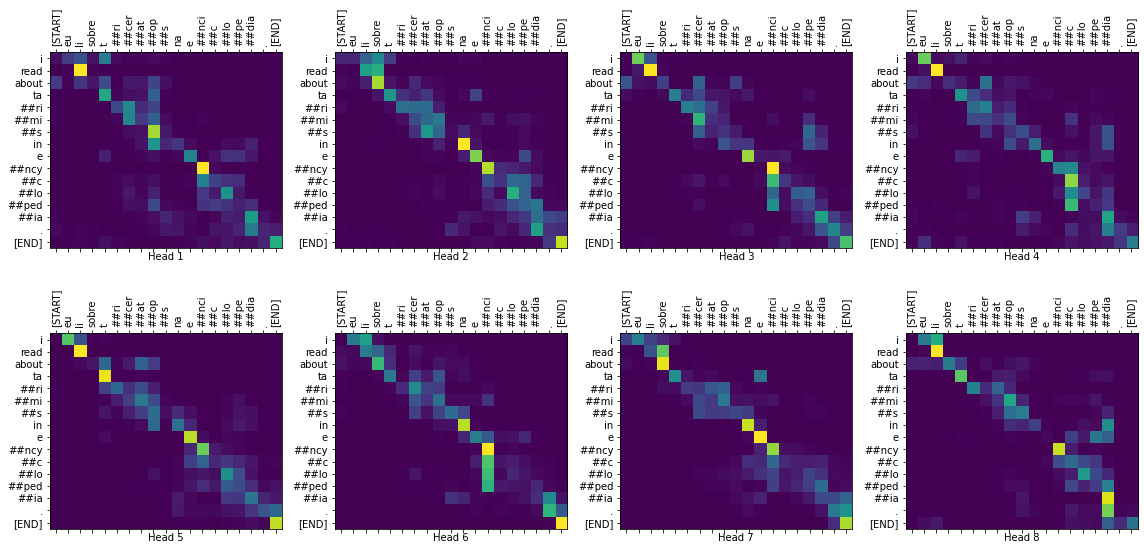

In [47]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0]) # num_head 쪼갠 8개 별로 생성된 attention_weights

### 추가 작업
- validation set으로 결과 성능 확인 / validation acc, loss?
- test set으로 모델 테스트

In [48]:
## validation Set으로 결과 성능 확인
#train_examples, val_examples = examples['train'], examples['validation']
#train_batches = make_batches(train_examples) # make_batches : token화 -> tensor -> batch
#val_batches = make_batches(val_examples)
'''
for (batch, (inp, tar)) in enumerate(val_batches):
    print(batch, inp)
'''
# test set 확인

#evaluate 함수에 토큰,벡터화 다 되어있고 model에 맞춰 돌리는 거 까지 구현되어있는 듯
##-> examples['validation]만 사용해서 확인 가능할 듯
# accuracy_function(real, pred)으로 validatin_acc 확인

'\nfor (batch, (inp, tar)) in enumerate(val_batches):\n    print(batch, inp)\n'

### 확인

In [51]:
#tokenizers.pt.get_vocab_size() # 7765
#tokenizers.en.get_vocab_size() # 7010

<tf.Tensor: shape=(), dtype=int32, numpy=7010>